In [1]:
#%%
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pandas as pd
from pennylane import numpy as np
import pennylane as qml
import tensorflow as tf
model_name = 'Q1' #Used for saving training charakteristics file
n_qubits = 4 #Number of qubits should be the same as number of features, max number = 25
dev = qml.device("default.qubit.tf", wires=n_qubits) #Run the model in classical CPU
blocks = 1 #Νumber of blocks (AngleEmbedding and StronglyEntanglingLayers is one block )
layers = 1  #layers per block (multiple “layers” of StronglyEntanglingLayers per block )
Epochs=100
batch_size=32
LR=0.001 # Learning rate
patience= 100 #For early stopping
# Set the split ratios
train_ratio = 0.75  # 70% for training
val_ratio = 0.15  # 15% for validation
ms = 'MS377'

#%%
df = pd.read_csv('traffic_mar23.csv',delimiter=';').iloc[:,1:]
d1 = df[ms]
from lstm_data_preparation import lstm_data
x0, y0 = lstm_data(d1,ms,8)
x0 = x0.reshape(x0.shape[0],x0.shape[1],1)
#%%

# Calculate the lengths of each set
total_length = len(x0)
train_length = int(total_length * train_ratio)
val_length = int(total_length * val_ratio)
test_length = total_length - train_length - val_length

# Split the data
x_train = x0[:train_length]
y_train = y0[:train_length]
x_val = x0[train_length:train_length+val_length]
y_val = y0[train_length:train_length+val_length]
x_test = x0[train_length+val_length:]
y_test = y0[train_length+val_length:]

# Print the shapes of the datasets
print("Training data shape:", x_train.shape, y_train.shape)
print("Validation data shape:", x_val.shape, y_val.shape)
print("Testing data shape:", x_test.shape, y_test.shape)

##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################

from sklearn.preprocessing import MinMaxScaler
# Preprocess the data
scaler = MinMaxScaler()
from sklearn.preprocessing import MinMaxScaler
# Preprocess the data
scaler = MinMaxScaler()

x_train_scaled = x_train
# Scale the validation dataset
x_val_scaled = x_val

# Scale the test dataset
x_test_scaled = x_test

# Scale the training dataset
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)

# Scale the validation dataset
x_val_scaled = scaler.transform(x_val.reshape(-1, 1)).reshape(x_val.shape)

# Scale the test dataset
x_test_scaled = scaler.transform(x_test.reshape(-1, 1)).reshape(x_test.shape)
y_train =  scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_val =  scaler.fit_transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
y_test =  scaler.fit_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

#%%
'''from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
d1.iloc[:,:-1] = scaler.fit_transform(d1.iloc[:,:-1])
corr=d1.corr()'''
#%%

##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################

# Define quantum node
# Added below to ensure the QNode is JIT compiled
@tf.function
@qml.qnode(dev, interface="tf", diff_method="backprop")
def qnode(inputs, weights):
    for i in range(blocks):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights[i], wires=range(n_qubits)) #STRONGLY ENTANGLING LAYERS
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weights_shape = (blocks, layers, n_qubits, 3) # Uncomment for Strongly entangling layers
tf.keras.backend.set_floatx("float32")
weight_shapes = {"weights": weights_shape}
inputs = tf.constant(np.random.random((batch_size, n_qubits)))

##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
from tensorflow import keras
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
#%%

opt = keras.optimizers.Adam(
        learning_rate=LR) 

with tf.device('/device:GPU:0'):
    tf.keras.backend.set_floatx("float32")
    weight_shapes = {"weights": weights_shape}
    layer_1= tf.keras.layers.LSTM(512, activation='linear', input_shape=(x0.shape[1],x0.shape[2])) ### input shape: timesteps, features
    layer_2 = tf.keras.layers.Dense(256, activation="linear", dtype=tf.float32)
    layer_3 = tf.keras.layers.Dense(128, activation="linear", dtype=tf.float32)
    layer_4 = tf.keras.layers.Dense(64, activation="linear", dtype=tf.float32)
    layer_5 = tf.keras.layers.Dense(n_qubits, activation="linear", dtype=tf.float32)
    #qlayer= tf.keras.layers.Dense(n_qubits, activation="linear", dtype=tf.float32) #Classical
    qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, n_qubits, dtype=tf.float32) 
    layer_6 = tf.keras.layers.Dense(4, activation="linear", dtype=tf.float32)
    layer_D = tf.keras.layers.Dense(1, activation="linear", dtype=tf.float32)
    
    model1 = tf.keras.models.Sequential([layer_1,layer_2,layer_3,layer_4,layer_5,qlayer,layer_6,layer_D])

#model1 = Sequential([
#LSTM(256,return_sequences=True, input_shape=(x0.shape[1],x0.shape[2])),
#Dense(128, input_shape=(x0.shape[1],x0.shape[2])),
#Dense(64),
#Dense(2),
#qlayer,
#Dense(1)
#])
    
#Compile model
model1.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error',"MAPE","MAE"])
# Define the EarlyStopping callback
#early_stopping = EarlyStopping(monitor='mean_absolute_error', patience=patience, verbose=1)
#Fit model
print(model1.summary())
history = model1.fit(x_train_scaled, y_train, epochs=Epochs, batch_size=32
                     ,validation_data=(x_val_scaled, y_val), shuffle=False)
#%%

# Save the training history to a file
history_file = model_name + "_history.txt"
with open(history_file, 'w') as file:
    file.write(str(history.history))

history_file = model_name + "_Summary.txt"
with open(history_file, 'w') as file:
    # Get the summary of the model architecture as a string
    summary_string = []
    model1.summary(print_fn=lambda x: summary_string.append(x))
# Process the summary string into a pandas DataFrame
    summary_data = [x.split() for x in summary_string[1:-1]]
    summary_df = pd.DataFrame(summary_data, columns=['Layer', 'Output','Shape', 'Param',"type","#"])
    file.write(str(summary_df[['Output','Param']].dropna()))
    
# Save the training characteristics
#characteristics_file = model_name + "_characteristics.txt"
#with open(characteristics_file, 'w') as file:
#    file.write("Loss: {}\n".format(history.history['loss'][-1]))
    
#    file.write("Validation Loss: {}\n".format(history.history['val_loss'][-1]))

C:\Users\Quantum\anaconda3\envs\Quantum\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training data shape: (403, 8, 1) (403,)
Validation data shape: (80, 8, 1) (80,)
Testing data shape: (55, 8, 1) (55,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1052672   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
 keras_layer (KerasLayer)    (None, 4)                 0 (unused)
     

13/13 [==============================] - 2s 158ms/step - loss: 0.0124 - mean_absolute_error: 0.0740 - MAPE: 1764388.0000 - MAE: 0.0740 - val_loss: 0.0253 - val_mean_absolute_error: 0.1355 - val_MAPE: 5452592.5000 - val_MAE: 0.1355
Epoch 29/100
13/13 [==============================] - 2s 171ms/step - loss: 0.0124 - mean_absolute_error: 0.0735 - MAPE: 1766343.1250 - MAE: 0.0735 - val_loss: 0.0254 - val_mean_absolute_error: 0.1359 - val_MAPE: 5405561.0000 - val_MAE: 0.1359
Epoch 30/100
13/13 [==============================] - 2s 168ms/step - loss: 0.0123 - mean_absolute_error: 0.0731 - MAPE: 1766719.0000 - MAE: 0.0731 - val_loss: 0.0253 - val_mean_absolute_error: 0.1357 - val_MAPE: 5379863.0000 - val_MAE: 0.1357
Epoch 31/100
13/13 [==============================] - 2s 155ms/step - loss: 0.0122 - mean_absolute_error: 0.0727 - MAPE: 1768358.7500 - MAE: 0.0727 - val_loss: 0.0252 - val_mean_absolute_error: 0.1354 - val_MAPE: 5354145.5000 - val_MAE: 0.1354
Epoch 32/100
13/13 [=================

Epoch 62/100
13/13 [==============================] - 2s 153ms/step - loss: 0.0108 - mean_absolute_error: 0.0674 - MAPE: 1788899.0000 - MAE: 0.0674 - val_loss: 0.0238 - val_mean_absolute_error: 0.1352 - val_MAPE: 4657742.0000 - val_MAE: 0.1352
Epoch 63/100
13/13 [==============================] - 2s 166ms/step - loss: 0.0107 - mean_absolute_error: 0.0673 - MAPE: 1788842.5000 - MAE: 0.0673 - val_loss: 0.0237 - val_mean_absolute_error: 0.1352 - val_MAPE: 4643316.5000 - val_MAE: 0.1352
Epoch 64/100
13/13 [==============================] - 2s 153ms/step - loss: 0.0107 - mean_absolute_error: 0.0673 - MAPE: 1788704.5000 - MAE: 0.0673 - val_loss: 0.0237 - val_mean_absolute_error: 0.1352 - val_MAPE: 4629603.0000 - val_MAE: 0.1352
Epoch 65/100
13/13 [==============================] - 2s 155ms/step - loss: 0.0107 - mean_absolute_error: 0.0673 - MAPE: 1788483.5000 - MAE: 0.0673 - val_loss: 0.0237 - val_mean_absolute_error: 0.1353 - val_MAPE: 4616730.5000 - val_MAE: 0.1353
Epoch 66/100
13/13 [====

13/13 [==============================] - 2s 169ms/step - loss: 0.0100 - mean_absolute_error: 0.0653 - MAPE: 1788386.5000 - MAE: 0.0653 - val_loss: 0.0236 - val_mean_absolute_error: 0.1359 - val_MAPE: 4576246.5000 - val_MAE: 0.1359
Epoch 96/100
13/13 [==============================] - 2s 172ms/step - loss: 0.0100 - mean_absolute_error: 0.0652 - MAPE: 1788755.8750 - MAE: 0.0652 - val_loss: 0.0236 - val_mean_absolute_error: 0.1359 - val_MAPE: 4577937.0000 - val_MAE: 0.1359
Epoch 97/100
13/13 [==============================] - 2s 162ms/step - loss: 0.0100 - mean_absolute_error: 0.0652 - MAPE: 1789103.3750 - MAE: 0.0652 - val_loss: 0.0236 - val_mean_absolute_error: 0.1359 - val_MAPE: 4579640.0000 - val_MAE: 0.1359
Epoch 98/100
13/13 [==============================] - 2s 169ms/step - loss: 0.0100 - mean_absolute_error: 0.0651 - MAPE: 1789429.8750 - MAE: 0.0651 - val_loss: 0.0236 - val_mean_absolute_error: 0.1359 - val_MAPE: 4581357.5000 - val_MAE: 0.1359
Epoch 99/100
13/13 [=================

Test RMSE: 0.8446466241594696
Test MAE: 0.6638963327019555
Test MAPE: 68039095348580.69


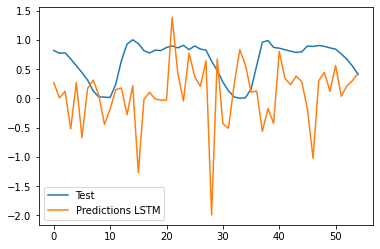

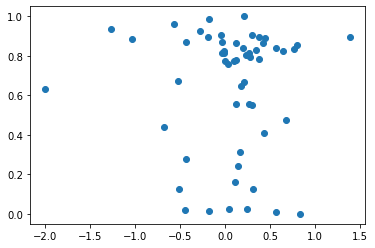

In [2]:
pre = model1.predict(x_test)
print("Test RMSE:", mean_squared_error(y_test, pre, squared=False))
print("Test MAE:", mean_absolute_error(y_test, pre))
print("Test MAPE:", mean_absolute_percentage_error(y_test,pre))
#%%
import matplotlib.pyplot as plt
plt.plot(y_test, label='Test ')
plt.plot(pre, label='Predictions LSTM')
plt.legend()
plt.show()
#%%
plt.scatter(pre, y_test)
plt.show()

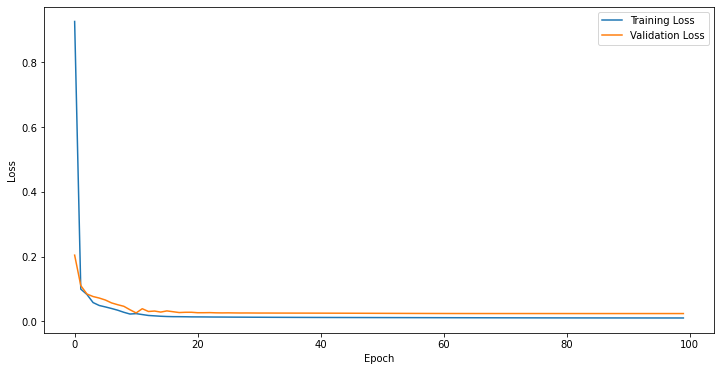

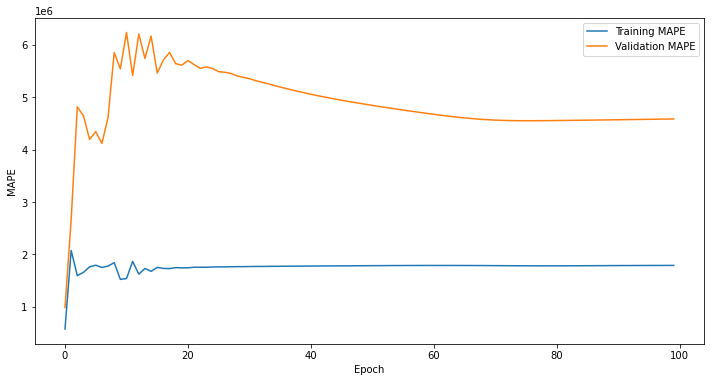

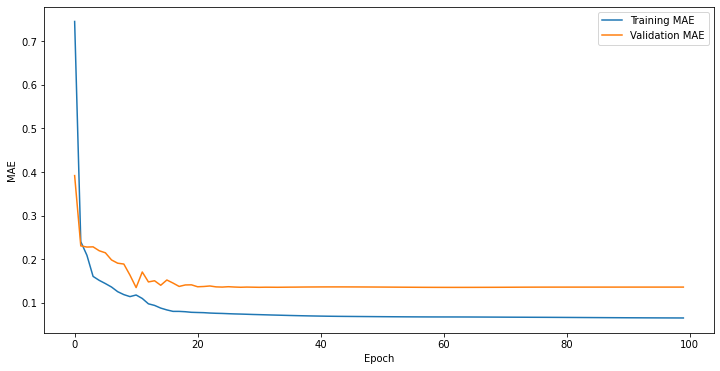

In [3]:
# Plot training characteristics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['MAPE'], label='Training MAPE')
plt.plot(history.history['val_MAPE'], label='Validation MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
#plt.ylim(0, 200)  # Set the y-axis limits
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['MAE'], label='Training MAE')
plt.plot(history.history['val_MAE'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

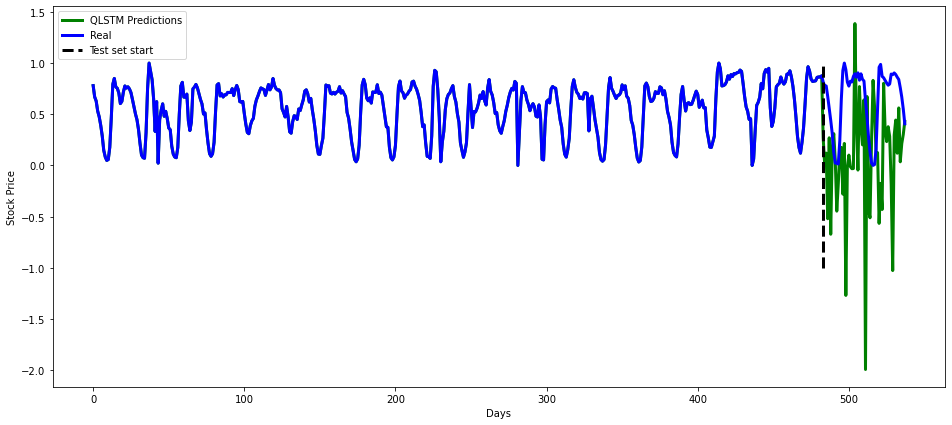

In [4]:
plt.figure(figsize=(16, 7))
#plt.plot(np.concatenate((y_train,y_val, y_test)), label='Test ')
plt.plot(np.array(np.concatenate((y_train,y_val, np.array(pre).flatten()))), label='QLSTM Predictions', linewidth=3, color="green")
plt.plot(np.concatenate((y_train,y_val,y_test)), label='Real', linewidth=3, color="blue")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(len(np.array(np.concatenate((y_train,y_val)))), ymin = -1, ymax = 1, label = "Test set start", linestyles = "dashed", linewidth=3, color="black")
plt.legend()
plt.show()

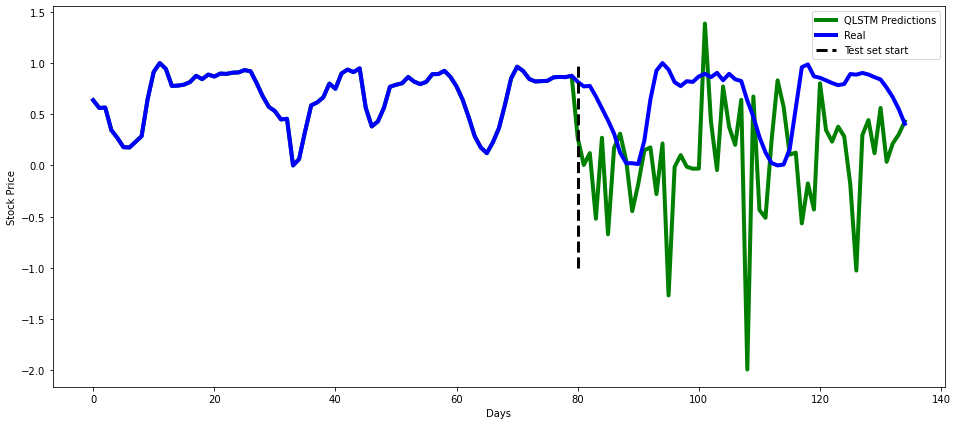

In [5]:
plt.figure(figsize=(16, 7))
#plt.plot(np.concatenate((y_train,y_val, y_test)), label='Test ')
plt.plot(np.array(np.concatenate((y_val, np.array(pre).flatten()))), label='QLSTM Predictions'
         , linewidth=4, color="green")
plt.plot(np.concatenate((y_val,y_test)), label='Real', linewidth=4, color="blue")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(len((y_val)), ymin = -1, ymax = 1, label = "Test set start", linestyles = "dashed", linewidth=3, color="black")
plt.legend()
plt.show()

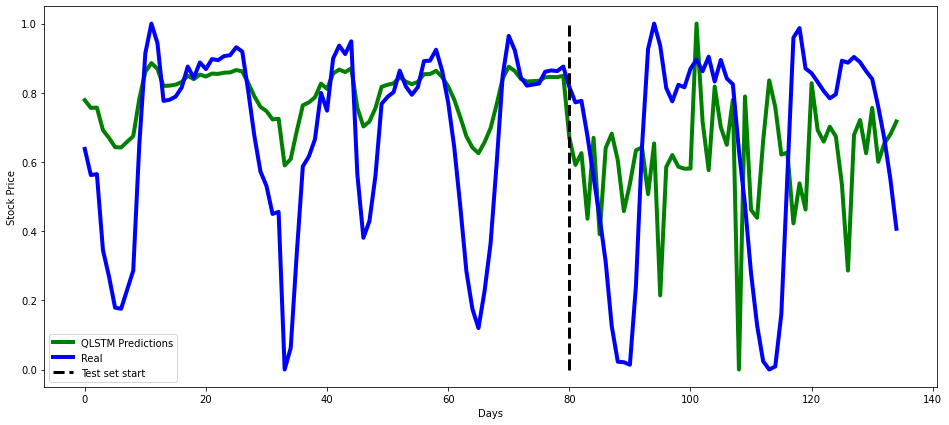

In [6]:
#Scaling predictions if needed
array=np.array(np.concatenate((y_val, np.array(pre).flatten())))
A = np.array([(x - min(array)) / (max(array) - min(array)) for x in array])
array=np.concatenate((y_val,y_test))
B = np.array([(x - min(array)) / (max(array) - min(array)) for x in array])
plt.figure(figsize=(16, 7))
#plt.plot(np.concatenate((y_train,y_val, y_test)), label='Test ')
plt.plot(A, label='QLSTM Predictions'
         , linewidth=4, color="green")
plt.plot(B, label='Real', linewidth=4, color="blue")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(len((y_val)), ymin = 0, ymax = 1, label = "Test set start", linestyles = "dashed", linewidth=3, color="black")
plt.legend()
plt.show()

In [7]:
# Save plots to a file
# Create a DataFrame from the arrays
import pandas as pd
df1 = pd.DataFrame()
file_name = model_name + "_plots.csv"
arr1=np.concatenate((y_train,y_val,y_test))
arr2=np.concatenate((y_train,y_val, np.array(pre).flatten()))
#df = pd.DataFrame({'Real': arr1,  'QLSTM': arr2})
column_name = "QLSTM_" + model_name
# Add the array to the specified column
df1["Real"] = arr1
df1[column_name] = arr2
# Save the DataFrame as a CSV file
df1.to_csv(file_name, index=False)
print("Arrays saved as", file_name)

Arrays saved as Q1_plots.csv
